In [3]:
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

#### Lazy老师说， synthetic data很有用, 用一个假数据试试

**实际的30日LTV分布，按照不同金额段来看，都是一个指数分布的样子， 合到一起，是一个极其偏的分布**

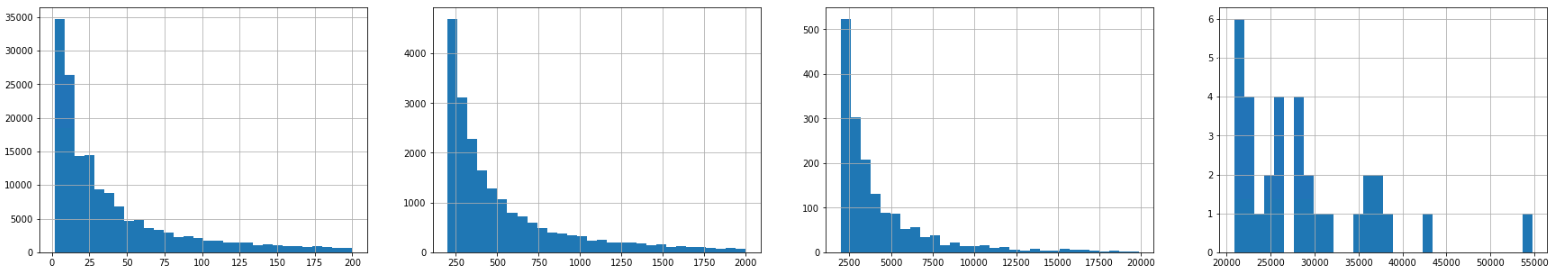

#### 假数据： 用两个不同大小的指数分布，合到一起，造成一个贼偏的数据

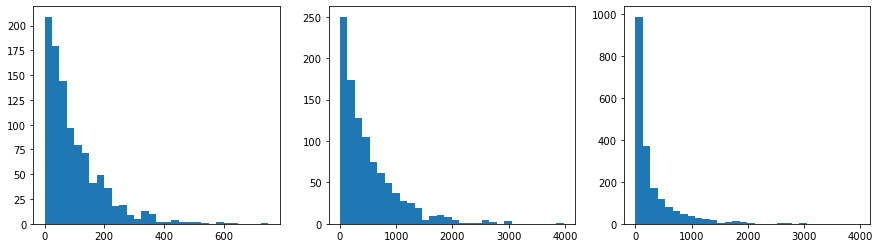

In [4]:
a1 = np.random.exponential(100, size = 1000)
a2 = np.random.exponential(500, size = 1000)
                                                                             

figsize(15,4)
plt.subplot(1,3,1)
plt.hist(a1, bins = 30)

plt.subplot(1,3,2)
plt.hist(a2, bins = 30)

plt.subplot(1,3,3)
plt.hist(np.r_[a1, a2], bins = 30)
plt.show()

## 做一些假设，假设，总共有两个类别，对每个类别，有那么一个先验

In [7]:
data = np.r_[a1, a2]

clusters = 2
n_total = len(data)

priors = [200, 600]

## 用pymc搞一搞

In [8]:
with pm.Model() as arpu_model:
    
    # 迪利克雷分布生成一个离散的multinomial
    p = pm.Dirichlet('p', a=np.ones(clusters))
    
    # 对数据集里面的每一个数据点，按照概率打label
    category = pm.Categorical('category', p=p, shape=n_total)
    
    # 估计likehood的参数 lambda， 假设又两个组，先验是priors
    lambdas = pm.Normal('lambdas', mu = priors, sd = 300, shape = clusters)
    
    # likelihood的构造
    y = pm.Exponential('y', lam=1 / lambdas[category], observed=data)
    
    # 分类变量
    step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
    
    # 连续变量，避免出错， metropolis
    step2 = pm.Metropolis(vars=[p, lambdas])
    trace = pm.sample(10000, step=[step1, step2], return_inferencedata = True)

<ipython-input-8-76d98e817efd>:16: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>ElemwiseCategorical: [category]
>CompoundStep
>>Metropolis: [lambdas]
>>Metropolis: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 332 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
figsize(15,6)

## 两个指数分布lambda的估计

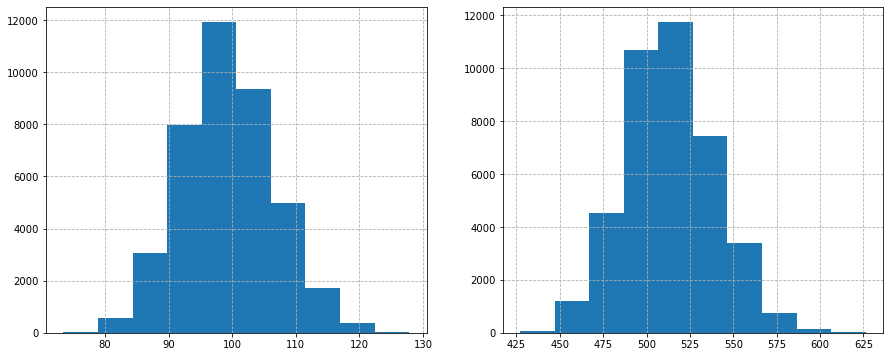

In [14]:
plt.subplot(1,2,1)
plt.hist(trace.posterior['lambdas'].values[:,:,0].reshape(-1))
plt.grid(linestyle = '--')
plt.subplot(1,2,2)
plt.hist(trace.posterior['lambdas'].values[:,:,1].reshape(-1))
plt.grid(linestyle = '--')
plt.show()

In [15]:
import arviz as az

## 对任意一个点，被分配到两个cluster的概率

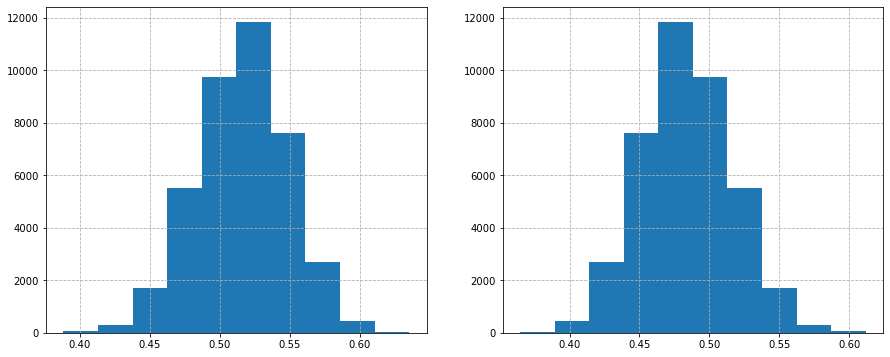

In [23]:
plt.subplot(1,2,1)
plt.hist(trace.posterior['p'].values[:,:,0].reshape(-1))
plt.grid(linestyle = '--')
plt.subplot(1,2,2)
plt.hist(trace.posterior['p'].values[:,:,1].reshape(-1))
plt.grid(linestyle = '--')

## 这样我们就用两个分布代替了一个分布

In [31]:
arpu = pd.read_csv('arpu.csv')['amount'].values

In [34]:
import pymc3 as pm
import arviz as az

clusters = 4
n_total = len(arpu)
priors = [20,30,3000,25000]

with pm.Model() as arpu_model:
    
    # 迪利克雷分布生成一个离散的multinomial
    p = pm.Dirichlet('p', a=np.ones(clusters))
    
    # 对数据集里面的每一个数据点，按照概率打label
    category = pm.Categorical('category', p=p, shape=n_total)
    
    # 估计likehood的参数 lambda， 假设又两个组，先验是priors
    lambdas = pm.Normal('lambdas', mu = priors, sd = 1000, shape = clusters)
    
    # likelihood的构造
    y = pm.Exponential('y', lam=1 / lambdas[category], observed=arpu)
    
    # 分类变量
    step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
    
    # 连续变量，避免出错， metropolis
    step2 = pm.Metropolis(vars=[p, lambdas])
    trace = pm.sample(100, step=[step1, step2], return_inferencedata = True)

<ipython-input-34-09f0f414d8d5>:25: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>ElemwiseCategorical: [category]
>CompoundStep
>>Metropolis: [lambdas]
>>Metropolis: [p]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 2846 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
pm.Gamma()